In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

from torch.utils.data import DataLoader, dataset, TensorDataset

In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../insight')
from archive import archive 

import torch.nn.functional as F

In [5]:
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

photoz_archive = archive(path = parent_dir, Qz_cut=0.5)
f, ferr, specz, specqz = photoz_archive.get_training_data()



In [83]:
dset = TensorDataset(torch.Tensor(f),torch.Tensor(specz))
loader = DataLoader(dset, batch_size=100, shuffle=True)

In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)


    return torch.mean(XX + YY - 2. * XY)

In [18]:
class InvertedPlanarFlow(nn.Module):
    """Implementation of the invertible transformation used in planar flow:
        f(z) = z + u * h(dot(w.T, z) + b)
    See Section 4.1 in https://arxiv.org/pdf/1505.05770.pdf. 
    """
    def __init__(self, n_dims):
        super(InvertedPlanarFlow, self).__init__()
        self.n_dims=n_dims
        
    def _assign_params_flow(self, flow_params):
        
        # Extract the u, w, and b components from flow_params
        u = flow_params[:, :self.n_dims]
        w = flow_params[:, self.n_dims:(2* self.n_dims)]
        b = flow_params[:, -1].unsqueeze(1)
        
        # Update the parameters with the new values
        self.u = nn.Parameter(u)
        self.w = nn.Parameter(w)
        self.b = nn.Parameter(b)
        
    
    def forward(self, y, flow_params):
        self._assign_params_flow(flow_params)
        activation = y + self.w*y + self.b
        flow =  y + self.u * torch.tanh(activation)
        psi = (1 - torch.tanh(activation) ** 2) * self.w
        jacobian = 1 + psi * self.u
        det_jacobian = torch.abs(jacobian)
        return flow, det_jacobian
    
    
    def inverse(self, z):
        activation = z + self.w*z + self.b
        flow =  z - self.u * torch.tanh(activation)
        psi = (1 - torch.tanh(activation) ** 2) * self.w
        jacobian = 1 - psi* self.u
        det_jacobian = torch.abs(jacobian)
        return flow, det_jacobian
    
    

In [90]:
class ConditionalNormalizingFlow(nn.Module):
    def __init__(self, n_dims, n_context, n_flows):
        super(ConditionalNormalizingFlow, self).__init__()
        self.n_dims = n_dims
        self.n_flows = n_flows
        self.n_context = n_context
        self.base_distribution=D.Normal(torch.zeros(self.n_dims), torch.ones(self.n_dims))

        # Create the flow layers
        self.flows = nn.ModuleList([InvertedPlanarFlow(self.n_dims) for _ in range(n_flows)])

        # Context encoder network (maps context to flow parameters)
        self.encoder = nn.Sequential(
            nn.Linear(self.n_context, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, n_flows * (2 * n_dims + 1))  # u, w, b for each flow
        )
           

    def forward(self, y, context_data):
        # Compute flow parameters from the context
        flow_params = self.encoder(context_data).view(-1, self.n_flows, 2 * self.n_dims + 1)
        
        #forward prop:
        logdetjac_sum = 0
        for i in range(self.n_flows):
            if i == 0:
                z, det_jacobian = self.flows[i](y,flow_params[:, i, :])
            else:
                z, det_jacobian = self.flows[i](z,flow_params[:, i, :])
                
            logdetjac_sum += torch.log(det_jacobian)
            
        for i in range(self.n_flows):
            if i == 0:
                yp, det_jacobian = self.flows[i].inverse(z)
                yp = z*det_jacobian
            else:
                yp, det_jacobian = self.flows[i].inverse(yp)
                yp = yp*det_jacobian            
            
        return z, yp, logdetjac_sum
    
    def predict(self, z, context_data):
        # Compute flow parameters from the context
        flow_params = self.encoder(context_data).view(-1, self.n_flows, 2 * self.n_dims + 1)
            
        for i in range(self.n_flows):
            if i == 0:
                self.flows[i]._assign_params_flow(flow_params[:, i, :])
                yp, det_jacobian = self.flows[i].inverse(z)
                yp = yp*det_jacobian
            else:
                self.flows[i]._assign_params_flow(flow_params[:, i, :])
                yp, det_jacobian = self.flows[i].inverse(yp)
                yp = yp*det_jacobian            
            
        return yp
    

In [91]:
# Example usage
n_dims = 1
n_context=6
n_flows = 20
nepochs=200
# Define the dimensionality of z
z_dim = 1

base_distribution = D.Normal(torch.zeros(z_dim), torch.ones(z_dim))
#base_distribution_perturbation = D.Normal(torch.zeros(z_dim), epsilon**2*torch.ones(z_dim))

#data = torch.randn(batch_size, n_context)
#y = torch.randn(batch_size,1)
#mmd = MMDLoss()


In [95]:
#flow_model = ConditionalNormalizingFlow(n_dims, n_context, n_flows).to(device)
optimizer = optim.Adam(flow_model.parameters(), lr=1e-3, weight_decay=1e-4)
for e in range(nepochs):
    
    for x, y in loader:
        optimizer.zero_grad()
        z, yp, logdet_jacb = flow_model(y.unsqueeze(1).to(device),x.to(device))
        randomN_input = torch.randn(z.size(0), z.size(1)).to(device)
        z = torch.nan_to_num(z)
        assert False

        
        zloss = ((yp-y.to(device))**2).mean(1)
                
        logloss =  MMD(z,randomN_input, kernel='rbf')-base_distribution.log_prob(z.cpu()).to(device).mean() + logdet_jacb.mean() + zloss.mean()
        #logloss = -logloss.mean()

        logloss.backward()
        optimizer.step() 
    print('epoch',e,logloss)
                                           

AssertionError: 

In [94]:
z.shape

torch.Size([4, 1])

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,
        24., 16., 20.,  9.,  6.,  4.,  4.,  2.,  0.,  0.,  2.,  3.,  3.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([-5.        , -4.80000019, -4.5999999 , -4.4000001 , -4.19999981,
        -4.        , -3.79999995, -3.5999999 , -3.4000001 , -3.20000005,
        -3.        , -2.79999995, -2.5999999 , -2.4000001 , -2.20000005,
        -2.        , -1.79999995, -1.60000002, -1.39999998, -1.20000005,
        -1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ,  1.20000005,  1.39999998,  1.60000002,  1.79999995,
         2.        ,  2.20000005,  2.4000001 ,  2.5999999 ,  2.79999995,
         3.        ,  3.20000005,  3.4000001 ,  3.5999999 ,  3.79999995,
         4.        ,  4.19999981,  4.4000001 ,  4.5999999 ,

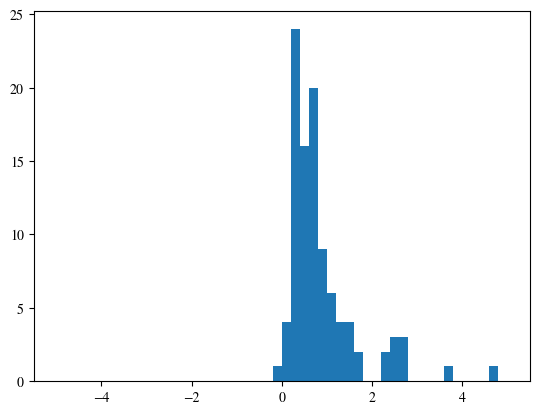

In [96]:
plt.hist(z.detach().cpu().numpy(), bins = 50, range = (-5,5))

In [97]:
y[:10]

tensor([1.2950, 0.3657, 0.4153, 0.3495, 0.6173, 0.3576, 1.1720, 0.7188, 0.5605,
        0.3393])

In [98]:
yp[:10]

tensor([[1.1834],
        [0.2864],
        [0.3292],
        [0.2728],
        [0.5064],
        [0.2797],
        [1.0441],
        [0.6005],
        [0.4555],
        [0.2642]], device='cuda:0', grad_fn=<SliceBackward0>)

In [101]:
Ntest=1
zs = base_distribution.sample(sample_shape=torch.Size([1000]))
ppz = np.zeros(shape=(Ntest,1000))
for ii in range(Ntest):
    for jj,z in enumerate(zs):
        ypred = flow_model.predict(z.unsqueeze(0).to(device),x[ii].unsqueeze(0).to(device))
        ppz[ii,jj] = ypred

(array([ 17.,  49., 135., 202., 251., 193., 100.,  40.,  10.,   3.]),
 array([-2.72178793, -2.09639964, -1.47101135, -0.84562306, -0.22023478,
         0.40515351,  1.0305418 ,  1.65593009,  2.28131838,  2.90670667,
         3.53209496]),
 <BarContainer object of 10 artists>)

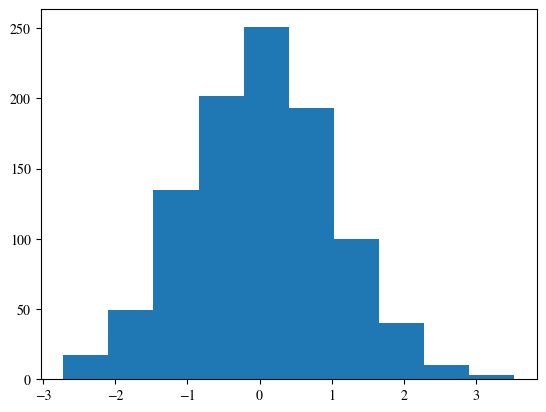

In [106]:
plt.hist(ppz[0])

In [79]:
class RadialFlow(nn.Module):
    def __init__(self, input_dim):
        super(RadialFlow, self).__init__()
        self.n_dims=n_dims
        
    def _assign_params_flow(self, flow_params):
        
        # Extract the u, w, and b components from flow_params
        alpha = flow_params[:, :self.n_dims]
        beta = flow_params[:, self.n_dims:(2* self.n_dims)]
        gamma = flow_params[:, -1].unsqueeze(1)
        
        # Update the parameters with the new values
        self.alpha = nn.Parameter(alpha)
        self.beta = nn.Parameter(beta)
        self.gamma = nn.Parameter(gamma)

    def forward(self, z, flow_params):
        
        self._assign_params_flow(flow_params)

        
        num = softplus(self.alpha) * (torch.exp(self.beta)-1) * (z - self.gamma) 
        den = softplus(self.alpha) + (z - self.gamma) 
        
        z_flow = z + num / den
        
        r = torch.abs(z-self.gamma)
        h = 1 / (softplus(self.alpha) + r)
        
        term1 = (1 + softplus(self.alpha) * (torch.exp(self.beta)-1) * h)**(self.n_dims -1)
        term2 = 1 + softplus(self.alpha) * (torch.exp(self.beta)-1) * h + softplus(self.alpha) * (torch.exp(self.beta)-1) * r *h**2
        
        det_jacobian = term1*term2
        
        return z_flow, det_jacobian
    
    def inverse(self, z):
        
        num = softplus(self.alpha) * (torch.exp(self.beta)-1) * (z - self.gamma) 
        den = softplus(self.alpha) + (z - self.gamma) 
        
        z_flow = z - num / den
        
        r = torch.abs(z-self.gamma)
        h = 1 / (softplus(self.alpha) + r)
        
        term1 = (1 + softplus(self.alpha) * (torch.exp(self.beta)-1) * h)**(self.n_dims -1)
        term2 = 1 - softplus(self.alpha) * (torch.exp(self.beta)-1) * h - softplus(self.alpha) * (torch.exp(self.beta)-1) * r *h**2
        
        det_jacobian = term1*term2
        
        return z_flow, det_jacobian
    

In [80]:
class ConditionalNormalizingFlow(nn.Module):
    def __init__(self, n_dims, n_context, n_flows):
        super(ConditionalNormalizingFlow, self).__init__()
        self.n_dims = n_dims
        self.n_flows = n_flows
        self.n_context = n_context
        self.base_distribution=D.Normal(torch.zeros(self.n_dims), torch.ones(self.n_dims))

        # Create the flow layers
        self.flows = nn.ModuleList([RadialFlow(self.n_dims) for _ in range(n_flows)])

        # Context encoder network (maps context to flow parameters)
        self.encoder = nn.Sequential(
            nn.Linear(self.n_context, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, n_flows * (2 * n_dims + 1))  # u, w, b for each flow
        )
           

    def forward(self, y, context_data):
        # Compute flow parameters from the context
        flow_params = self.encoder(context_data).view(-1, self.n_flows, 2 * self.n_dims + 1)
        
        #forward prop:
        logdetjac_sum = 0
        for i in range(self.n_flows):
            if i == 0:
                z, det_jacobian = self.flows[i](y,flow_params[:, i, :])
            else:
                z, det_jacobian = self.flows[i](z,flow_params[:, i, :])
                
            logdetjac_sum += torch.log(det_jacobian)
            
        for i in range(self.n_flows):
            if i == 0:
                yp, det_jacobian = self.flows[i].inverse(z)
                yp = z*det_jacobian
            else:
                yp, det_jacobian = self.flows[i].inverse(yp)
                yp = yp*det_jacobian            
            
        return z, yp, logdetjac_sum
    
    def predict(self, z, context_data):
        # Compute flow parameters from the context
        flow_params = self.encoder(context_data).view(-1, self.n_flows, 2 * self.n_dims + 1)
            
        for i in range(self.n_flows):
            if i == 0:
                self.flows[i]._assign_params_flow(flow_params[:, i, :])
                yp, det_jacobian = self.flows[i].inverse(z)
                yp = yp*det_jacobian
            else:
                self.flows[i]._assign_params_flow(flow_params[:, i, :])
                yp, det_jacobian = self.flows[i].inverse(yp)
                yp = yp*det_jacobian            
            
        return yp
    

In [84]:
flow_model = ConditionalNormalizingFlow(n_dims, n_context, n_flows).to(device)
optimizer = optim.Adam(flow_model.parameters(), lr=1e-3, weight_decay=1e-4)
for e in range(nepochs):
    
    for x, y in loader:
        optimizer.zero_grad()
        z, yp, logdet_jacb = flow_model(y.unsqueeze(1).to(device),x.to(device))
        randomN_input = torch.randn(z.size(0), z.size(1)).to(device)

        
        zloss = ((yp-y.to(device))**2).mean(1)
                
        logloss =  MMD(z,randomN_input, kernel='rbf')-base_distribution.log_prob(z.cpu()).to(device).mean() + logdet_jacb.mean() + zloss.mean()
        #logloss = -logloss.mean()

        logloss.backward()
        optimizer.step() 
    print('epoch',e,logloss)
                                           

ValueError: Expected value argument (Tensor of shape (100, 1)) to be within the support (Real()) of the distribution Normal(loc: tensor([0.]), scale: tensor([1.])), but found invalid values:
tensor([[0.8334],
        [1.0070],
        [1.9326],
        [0.6259],
        [0.3777],
        [0.4443],
        [0.7886],
        [0.7467],
        [0.7462],
        [0.7054],
        [1.1618],
        [0.5967],
        [0.5120],
        [0.6465],
        [0.0662],
        [0.2656],
        [0.8282],
        [0.7042],
        [0.3526],
        [0.4975],
        [2.7807],
        [0.4749],
        [0.8635],
        [0.4452],
        [1.1419],
        [0.4767],
        [0.7106],
        [0.5398],
        [0.7557],
        [0.6760],
        [0.7165],
        [1.1008],
        [0.6860],
        [3.5272],
        [0.6977],
        [0.3678],
        [1.4739],
        [0.8516],
        [1.0473],
        [1.0079],
        [0.5887],
        [1.1655],
        [0.8932],
        [0.4380],
        [0.6055],
        [0.8969],
        [0.7425],
        [0.6864],
        [0.9037],
        [0.5603],
        [2.1866],
        [0.3644],
        [0.1954],
        [1.1353],
        [0.3222],
        [3.0116],
        [3.8900],
        [0.9592],
        [2.2661],
        [2.4230],
        [0.7257],
        [   nan],
        [0.7326],
        [0.9051],
        [0.5102],
        [0.5501],
        [0.8331],
        [0.9098],
        [1.1535],
        [3.0428],
        [0.7206],
        [0.4672],
        [0.6801],
        [0.6882],
        [0.4479],
        [0.9945],
        [0.3963],
        [1.9218],
        [0.7609],
        [0.2332],
        [0.8465],
        [0.7598],
        [0.8371],
        [0.3823],
        [1.5190],
        [0.1409],
        [2.0572],
        [0.8513],
        [0.2356],
        [0.4411],
        [0.4399],
        [1.0175],
        [1.0340],
        [0.8210],
        [0.1267],
        [0.8957],
        [0.9660],
        [0.2468],
        [1.8487],
        [0.9320]], grad_fn=<ToCopyBackward0>)

In [55]:
zs

tensor([[ 0.8484],
        [ 1.6182],
        [ 0.8343],
        [-1.9827],
        [ 0.9152],
        [ 0.7381],
        [ 0.0629],
        [-0.8316],
        [ 2.1748],
        [-0.3499],
        [ 0.3545],
        [ 0.2066],
        [-0.2118],
        [ 1.2085],
        [-1.8986],
        [-1.0616],
        [ 0.7481],
        [ 0.1565],
        [-0.4269],
        [-1.6495],
        [-0.3292],
        [ 0.8947],
        [ 0.7817],
        [ 0.7382],
        [-0.6586],
        [ 0.8902],
        [ 0.0948],
        [ 0.1384],
        [-0.9999],
        [-0.4162],
        [-0.2117],
        [-0.6847],
        [-0.3855],
        [-1.1827],
        [ 0.5822],
        [-1.6971],
        [-0.9910],
        [ 0.7619],
        [-0.8828],
        [-0.1368],
        [-0.7045],
        [-0.1798],
        [ 1.1066],
        [-0.5498],
        [-1.2881],
        [ 1.1565],
        [ 1.1648],
        [-0.6986],
        [-1.8623],
        [ 0.9912],
        [ 0.3955],
        [ 0.4971],
        [ 0.

(array([  9.,  40.,  99., 148., 174., 156., 178., 131.,  53.,  12.]),
 array([-3.92286921, -3.15244029, -2.38201137, -1.61158245, -0.84115353,
        -0.07072461,  0.69970431,  1.47013323,  2.24056215,  3.01099107,
         3.78141999]),
 <BarContainer object of 10 artists>)

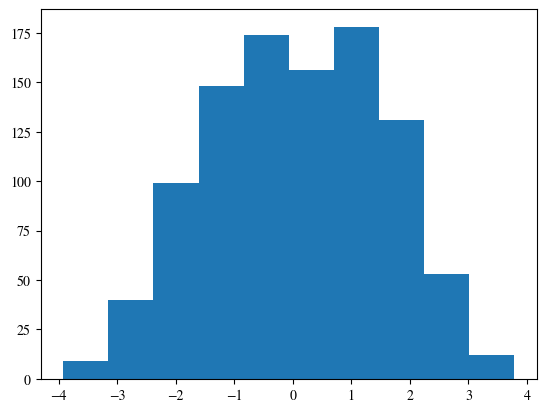

In [52]:
plt.hist(ppz[0])

In [53]:
ppz[0].mean()

0.06320796876773238

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  0.,  4.,  2.,  3.,
         2.,  1.,  3.,  0.,  0.,  3.,  2.,  8.,  5.,  4.,  4., 10.,  4.,
         8.,  7., 10., 10., 12., 19., 16., 14., 17., 24., 27., 36., 35.,
        26., 54., 32., 40., 44., 49., 45., 58., 54., 43., 31., 34., 22.,
        29., 19., 16., 12., 19., 15., 12., 11.,  9.,  2.,  5.,  6.,  2.,
         0.,  4.,  1.,  3.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([-2.11697197, -2.07361054, -2.03024936, -1.98688793, -1.94352663,
        -1.90016532, -1.85680389, -1.81344259, -1.77008128, -1.72671998,
        -1.68335855, -1.63999724, -1.59663594, -1.55327463, -1.50991321,
        -1.4665519 , -1.42319059, -1.37982929, -1.33646786, -1.29310656,
        -1.24974525, -1.20638394, -1.16302252, -1.11966121, -1.07629991,
        -1.03293848, -0.98957717, -0.94621587, -0.9028545 , -0.859493

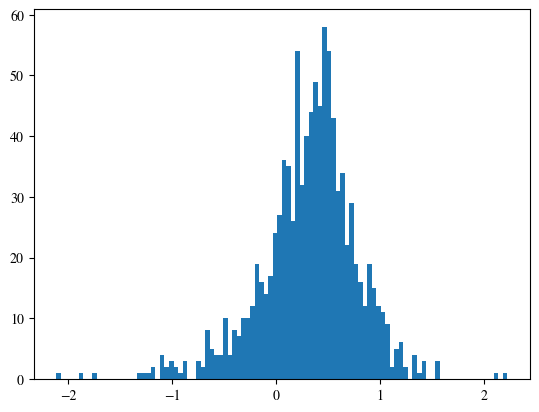

In [124]:
plt.hist(ypred, bins = 100)

In [113]:
ypred.mean()

0.25293207

## second part

In [206]:
import torch
import torch.distributions as D



In [331]:
base_distribution = D.normal.Normal(loc=0, scale=1)

In [333]:
# Sample from the base Gaussian distribution
z_sample = torch.Tensor([-13.4019])

# Compute log probability for a given sample
log_prob_z = base_distribution.log_prob(z_sample)
print("Log probability of the sample in the base distribution:")
print(log_prob_z)


Log probability of the sample in the base distribution:
tensor([-90.7244])


tensor([ 1.1044e+00,  5.3608e-01,  2.7223e-01, -4.0974e-01, -1.2630e+00,
         2.7436e-01,  4.5724e-01,  7.1562e-01,  2.5585e-01, -1.7401e+00,
         3.6557e-01,  1.9815e+00,  8.3127e-02, -2.8310e-02,  1.5944e-01,
        -1.5677e+00,  8.7571e-01, -1.4026e+00,  9.6980e-01, -5.7682e-01,
         2.6239e-01,  5.7484e-01, -5.7243e-01, -2.1229e-01,  6.5120e-01,
        -4.3072e-01,  4.2276e-01,  7.4024e-01, -5.8200e-01, -1.1932e+00,
        -7.1932e-01,  2.9953e-01,  1.0649e+00, -1.2855e-01,  3.5041e-01,
         4.8927e-01,  6.0499e-01,  1.1458e+00, -6.1707e-01,  2.1834e+00,
         9.1538e-01,  7.9090e-01,  6.4550e-01,  9.1880e-01,  3.5349e-01,
         8.1434e-01,  1.1906e-01, -5.1368e-01, -8.0531e-01,  3.7218e-01,
        -2.8462e-01,  5.1760e-01,  5.2333e-01, -1.1095e+00, -1.7090e-01,
        -5.8244e-02, -3.0572e-01,  2.3676e-01,  4.0046e-01,  9.4080e-01,
         1.8561e+00, -5.2990e-01,  5.1445e-02, -6.2367e-02,  5.9578e-01,
         1.5714e-01,  6.5467e-01,  5.2255e-01, -5.2

In [252]:
log_prob_z

Object `log_prob_z` not found.


In [ ]:
import torch
import torch.nn as nn
from torch import Tensor


class InvertedPlanarTransform(nn.Module):
    """Implementation of the invertible transformation used in planar flow:
        f(z) = z + u * h(dot(w.T, z) + b)
    See Section 4.1 in https://arxiv.org/pdf/1505.05770.pdf. 
    """

    def __init__(self, dim):
        """Initialise weights and bias.
        
        Args:
            dim: Dimensionality of the distribution to be estimated.
        """
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))

    def forward(self, z: Tensor) -> Tensor:
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()

        return z + self.u * nn.Tanh()(torch.mm(z, self.w.T) + self.b)
    
    def log_det_J(self, z: Tensor) -> Tensor:
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()
        a = torch.mm(z, self.w.T) + self.b
        psi = (1 - nn.Tanh()(a) ** 2) * self.w
        abs_det = (1 + torch.mm(self.u, psi.T)).abs()
        log_det = torch.log(1e-4 + abs_det)

        return log_det

    def get_u_hat(self) -> None:
        """Enforce w^T u >= -1. When using h(.) = tanh(.), this is a sufficient condition 
        for invertibility of the transformation f(z). See Appendix A.1.
        """
        wtu = torch.mm(self.u, self.w.T)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        self.u.data = (
            self.u + (m_wtu - wtu) * self.w / torch.norm(self.w, p=2, dim=1) ** 2
        )

    def inverse(self, x: Tensor) -> Tensor:
        """
        Compute the inverse transformation.

        Args:
            x: Input tensor.

        Returns:
            Inverse transformed tensor.
        """
        # Compute inverse of tanh using atanh (inverse hyperbolic tangent)
        inverse_h = torch.atanh((x - self.u) / torch.mm(self.w, self.w.T))

        # Compute the inverse transformation
        inverse_z = torch.mm(inverse_h - self.b, torch.inverse(self.w))

        return inverse_z


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConditionalPlanarFlowModel(nn.Module):
    def __init__(self, input_dim=6, target_dim=1, num_flows=1):
        super(ConditionalPlanarFlowModel, self).__init__()
        self.input_dim = input_dim
        self.target_dim = target_dim
        self.num_flows = num_flows

        # Create a list to hold the InvertedPlanarTransform instances
        self.flow_list = nn.ModuleList([InvertedPlanarTransform(dim=input_dim) for _ in range(num_flows)])

        # Linear layer to predict the CPD for the target variable
        self.linear_layer = nn.Linear(input_dim, target_dim)

    def forward(self, input_features):
        # Apply all the InvertedPlanarTransform instances sequentially
        transformed_features = input_features
        for flow in self.flow_list:
            transformed_features = flow(transformed_features)

        # Predict the CPD for the target variable
        predicted_cpd = self.linear_layer(transformed_features)

        return predicted_cpd


def train_model(model, input_data, target_data, num_epochs=100, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        predicted_cpd = model(input_data)
        loss = criterion(predicted_cpd, target_data)
        loss.backward()
        optimizer.step()

# Step 5: Inference
def predict_cpd(model, input_features):
    with torch.no_grad():
        model.eval()
        transformed_features = model.feature_transform.inverse(input_features)
        predicted_cpd = model.linear_layer(transformed_features)
    return predicted_cpd



In [ ]:
# Step 3: Define your loss function (e.g., negative log-likelihood)
criterion = nn.NLLLoss()  # Use a suitable loss function based on the nature of your CPD

# Step 4: Training the model

In [4]:
num_samples=10
input_dim=6
target_dim=1

In [5]:
# Assuming you have your input_data and target_data as torch tensors:
input_data = torch.randn(num_samples, input_dim)  # Replace with your actual data
target_data = torch.randn(num_samples, target_dim)  # Replace with your actual data

In [9]:
train_model(model, input_data, target_data)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [38]:
# Assuming you have your input_data and target_data as torch tensors:
input_data = torch.randn(num_samples, input_dim)  # Replace with your actual data
target_data = torch.randn(num_samples, target_dim)  # Replace with your actual data

# Step 2: Create the model

# Step 4: Train the model


# Step 5: Predict the CPD for new input features
new_input_features = torch.randn(num_samples, input_dim)  # Replace with your new data
predicted_cpd = predict_cpd(model, new_input_features)

TypeError: randn(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 2

In [32]:
torch.randn?

Docstring:
randn(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False, pin_memory=False) -> Tensor


Returns a tensor filled with random numbers from a normal distribution
with mean `0` and variance `1` (also called the standard normal
distribution).

.. math::
    \text{out}_{i} \sim \mathcal{N}(0, 1)

The shape of the tensor is defined by the variable argument :attr:`size`.

Args:
    size (int...): a sequence of integers defining the shape of the output tensor.
        Can be a variable number of arguments or a collection like a list or tuple.

Keyword args:
    generator (:class:`torch.Generator`, optional): a pseudorandom number generator for sampling
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
    layout (:class:`torch.layout`, optional): the desired layout of ret

In [17]:
class PlanarFlow(nn.Module):
    def __init__(self, dim: int = 2, K: int = 6):
        """Make a planar flow by stacking planar transformations in sequence.

        Args:
            dim: Dimensionality of the distribution to be estimated.
            K: Number of transformations in the flow. 
        """
        super().__init__()
        self.layers = [InvertedPlanarTransform(dim) for _ in range(K)]
        self.model = nn.Sequential(*self.layers)

    def forward(self, z: Tensor) -> Tuple[Tensor, float]:
        log_det_J = 0

        for layer in self.layers:
            log_det_J += layer.log_det_J(z)
            z = layer(z)

        return z, log_det_J

In [18]:
model = PlanarFlow(dim=2, K=2)

In [19]:
model

PlanarFlow(
  (model): Sequential(
    (0): InvertedPlanarTransform()
    (1): InvertedPlanarTransform()
  )
)

TypeError: object.__init__() takes exactly one argument (the instance to initialize)

In [12]:
planar_flow = InvertedPlanarFlow(params=torch.zeros((1, 2 * 1 + 1)), n_dims=1)

In [13]:
planar_flow

InvertedPlanarFlow()

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions


class BaseEstimator(tf.keras.Sequential):
    x_noise_std = tf.Variable(initial_value=0.0, dtype=tf.float32, trainable=False)
    y_noise_std = tf.Variable(initial_value=0.0, dtype=tf.float32, trainable=False)

    def __init__(self, layers, noise_fn_type="fixed_rate", noise_scale_factor=0.0, random_seed=22):
        tf.random.set_seed(random_seed)
        self.noise_fn_type = noise_fn_type
        self.noise_scale_factor = noise_scale_factor

        super().__init__(layers)

    def fit(self, x, y, batch_size=None, epochs=None, verbose=1, **kwargs):
        self._assign_data_normalization(x, y)
        assert len(x.shape) == len(y.shape) == 2, "Please pass a matrix not a vector"
        self._assign_noise_regularisation(n_dims=x.shape[1] + y.shape[1], n_datapoints=x.shape[0])
        super().fit(
            x=x,
            y=y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            callbacks=[tf.keras.callbacks.TerminateOnNaN()],
            **kwargs,
        )

    def _assign_noise_regularisation(self, n_dims, n_datapoints):
        assert self.noise_fn_type in ["rule_of_thumb", "fixed_rate"]
        if self.noise_fn_type == "rule_of_thumb":
            noise_std = self.noise_scale_factor * (n_datapoints + 1) ** (-1 / (4 + n_dims))
            self.x_noise_std.assign(noise_std)
            self.y_noise_std.assign(noise_std)
        elif self.noise_fn_type == "fixed_rate":
            self.x_noise_std.assign(self.noise_scale_factor)
            self.y_noise_std.assign(self.noise_scale_factor)

    def score(self, x_data, y_data):
        x_data = x_data.astype(np.float32)
        y_data = y_data.astype(np.float32)
        nll = self._get_neg_log_likelihood()
        return -nll(y_data, self.call(x_data, training=False)).numpy().mean()

    def _assign_data_normalization(self, x, y):
        self.x_mean = np.mean(x, axis=0, dtype=np.float32)
        self.y_mean = np.mean(y, axis=0, dtype=np.float32)
        self.x_std = np.std(x, axis=0, dtype=np.float32)
        self.y_std = np.std(y, axis=0, dtype=np.float32)

    def _get_neg_log_likelihood(self):
        y_input_model = self._get_input_model()
        return lambda y, p_y: -p_y.log_prob(y_input_model(y)) + tf.reduce_sum(
            tf.math.log(self.y_std)
        )

    def _get_input_model(self):
        y_input_model = tf.keras.Sequential()
        # add data normalization layer
        y_input_model.add(
            tf.keras.layers.Lambda(lambda y: (y - tf.ones_like(y) * self.y_mean) / self.y_std)
        )
        # noise will be switched on during training and switched off otherwise automatically
        y_input_model.add(tf.keras.layers.GaussianNoise(self.y_noise_std))
        return y_input_model

    def pdf(self, x, y):
        assert x.shape == y.shape
        output = self(x)
        y_circ = (y - tf.ones_like(y) * self.y_mean) / self.y_std
        return output.prob(y_circ) / tf.reduce_prod(self.y_std)

    def log_pdf(self, x, y):
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        assert x.shape == y.shape

        output = self(x)
        assert output.event_shape == y.shape[-1]

        y_circ = (y - tf.ones_like(y) * self.y_mean) / self.y_std
        return output.log_prob(y_circ) - tf.reduce_sum(tf.math.log(self.y_std))

2023-08-03 07:26:44.817779: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 07:26:47.725659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 07:27:10.847442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-03 07:27:53.690091: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at htt

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python import tf2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

if not tf2.enabled():
    import tensorflow.compat.v2 as tf

    tf.enable_v2_behavior()
    assert tf2.enabled()
tfd = tfp.distributions


class MeanFieldLayer(tfp.layers.DistributionLambda):
    def __init__(self, n_dims, scale=None, map_mode=False, dtype=None):
        """
        A subclass of Distribution Lambda. A layer that uses it's input to parametrize n_dims-many indepentent normal
        distributions (aka mean field)
        Requires input size n_dims for fixed scale, 2*n_dims for trainable scale
        Mean Field also works for scalars
        The input tensors for this layer should be initialized to Zero for a standard normal distribution
        :param n_dims: Dimension of the distribution that's being output by the Layer
        :param scale: (float) None if scale should be trainable. If not None, specifies the fixed scale of the
            independent normals. If map mode is activated, this is ignored and set to 1.0
        """
        self.n_dims = n_dims
        self.scale = scale

        if map_mode:
            self.scale = 1.0
        convert_ttf = tfd.Distribution.mean if map_mode else tfd.Distribution.sample

        make_dist_fn = self._get_distribution_fn(self.n_dims, self.scale)

        super().__init__(
            make_distribution_fn=make_dist_fn, convert_to_tensor_fn=convert_ttf, dtype=dtype
        )

    @staticmethod
    def _get_distribution_fn(n_dims, scale=None):
        if scale is None:

            def dist_fn(t):
                assert t.shape[-1] == 2 * n_dims
                return tfd.Independent(
                    tfd.Normal(
                        loc=t[..., 0:n_dims],
                        scale=1e-3
                        + tf.nn.softplus(
                            tf.math.log(tf.math.expm1(1.0)) + 0.05 * t[..., n_dims : 2 * n_dims]
                        ),
                    ),
                    reinterpreted_batch_ndims=1,
                )

        else:
            assert scale > 0.0

            def dist_fn(t):
                assert t.shape[-1] == n_dims
                return tfd.Independent(
                    tfd.Normal(loc=t[..., 0:n_dims], scale=scale), reinterpreted_batch_ndims=1
                )

        return dist_fn

    def get_total_param_size(self):
        return 2 * self.n_dims if self.scale is None else self.n_dims

In [44]:
import tensorflow_probability as tfp


class AffineFlow(tfp.experimental.joint_distribution_layers.Affine):
    def __init__(self, t, n_dims, name="AffineFlow"):
        assert t.shape[-1] == 2 * n_dims
        super(AffineFlow, self).__init__(
            shift=t[..., 0:n_dims], scale_diag=1.0 + t[..., n_dims : 2 * n_dims], name=name
        )

    @staticmethod
    def get_param_size(n_dims):
        """
        :param n_dims:  The dimension of the distribution to be transformed by the flow
        :return: (int) The dimension of the parameter space for the flow
        """
        return 2 * n_dims

In [45]:
test_radial()

TypeError: missing a required argument: 'out_units'

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp


class PlanarFlow(tfp.bijectors.Bijector):
    """
    Implements a bijector x = y + u * tanh(w_t * y + b)

    Args:
        params: Tensor shape (?, 2*n_dims+1). This will be split into the parameters
            u (?, n_dims), w (?, n_dims), b (?, 1).
            Furthermore u will be constrained to assure the invertability of the flow
        n_dims: The dimension of the distribution that will be transformed
        name: The name to give this particular flow

    """

    _u, _w, _b = None, None, None

    def __init__(self, t, n_dims, name="Inverted_Planar_Flow"):
        super().__init__(validate_args=False, name=name, inverse_min_event_ndims=1)
        assert t.shape[-1] == 2 * n_dims + 1
        u, w, b = (
            t[..., 0:n_dims],
            # initialize w to 1.0
            t[..., n_dims : 2 * n_dims] + 1,
            t[..., 2 * n_dims : 2 * n_dims + 1],
        )

        # constrain u before assigning it
        self._u = self._u_circ(u, w)
        self._w = w
        self._b = b

    @staticmethod
    def get_param_size(n_dims):
        """
        :param n_dims: The dimension of the distribution to be transformed by the flow
        :return: (int array) The dimension of the parameter space for this flow, n_dims + n_dims + 1
        """
        return n_dims + n_dims + 1

    @staticmethod
    def _u_circ(u, w):
        """
        To ensure invertibility of the flow, the following condition needs to hold: w_t * u >= -1
        :return: The transformed u
        """
        wtu = tf.math.reduce_sum(w * u, 1, keepdims=True)
        # add constant to make it more numerically stable
        m_wtu = -1.0 + tf.nn.softplus(wtu) + 1e-5
        norm_w_squared = tf.math.reduce_sum(w ** 2, 1, keepdims=True) + 1e-9
        return u + (m_wtu - wtu) * (w / norm_w_squared)

    def _wzb(self, z):
        """
        Computes w_t * z + b
        """
        return tf.math.reduce_sum(self._w * z, 1, keepdims=True) + self._b

    @staticmethod
    def _der_tanh(z):
        """
        Computes the derivative of hyperbolic tangent
        """
        return 1.0 - tf.math.tanh(z) ** 2

    def _forward(self, z):
        """
        Runs a forward pass through the bijector
        """
        return z + self._u * tf.math.tanh(self._wzb(z))

    def _forward_log_det_jacobian(self, z):
        """
        Computes the ln of the absolute determinant of the jacobian
        """
        psi = self._der_tanh(self._wzb(z)) * self._w
        det_grad = 1.0 + tf.math.reduce_sum(self._u * psi, 1)
        return tf.math.log(tf.math.abs(det_grad))

In [21]:
import tensorflow as tf
import tensorflow_probability as tfp


class RadialFlow(tfp.bijectors.Bijector):
    """
    Implements a bijector x = y + (alpha * beta * (y - y_0)) / (alpha + abs(y - y_0)).
    Args:
        params: Tensor shape (?, n_dims+2). This will be split into the parameters
            alpha (?, 1), beta (?, 1), gamma (?, n_dims).
            Furthermore alpha will be constrained to assure the invertability of the flow
        n_dims: The dimension of the distribution that will be transformed
        name: The name to give this particular flow
    """

    _alpha = None
    _beta = None
    _gamma = None

    def __init__(self, t, n_dims, name='RadialFlow'):
        super().__init__(validate_args=False, name=name, inverse_min_event_ndims=1)

        assert t.shape[-1] == n_dims + 2
        alpha = t[..., 0:1]
        beta = t[..., 1:2]
        gamma = t[..., 2 : n_dims + 2]

        # constraining the parameters before they are assigned to ensure invertibility.
        # slightly shift alpha, softplus(zero centered input - 2) = small
        self._alpha = self._alpha_circ(0.3 * alpha - 2.0)
        # slightly shift beta, softplus(zero centered input + ln(e - 1)) = 0
        self._beta = self._beta_circ(0.1 * beta + tf.math.log(tf.math.expm1(1.0)))
        self._gamma = gamma
        self.n_dims = n_dims

    @staticmethod
    def get_param_size(n_dims):
        """
        :param n_dims:  The dimension of the distribution to be transformed by the flow
        :return: (int) The dimension of the parameter space for the flow
        """
        return 1 + 1 + n_dims

    def _r(self, z):
        return tf.math.reduce_sum(tf.abs(z - self._gamma), 1, keepdims=True)

    def _h(self, r):
        return 1.0 / (self._alpha + r)

    def _forward(self, z):
        """
        Runs a forward pass through the bijector
        """
        r = self._r(z)
        h = self._h(r)
        return z + (self._alpha * self._beta * h) * (z - self._gamma)

    def _forward_log_det_jacobian(self, z):
        """
        Computes the ln of the absolute determinant of the jacobian
        """
        r = self._r(z)
        with tf.GradientTape() as g:
            g.watch(r)
            h = self._h(r)
        der_h = g.gradient(h, r)
        ab = self._alpha * self._beta
        det = (1.0 + ab * h) ** (self.n_dims - 1) * (1.0 + ab * h + ab * der_h * r)
        det = tf.squeeze(det, axis=-1)
        return tf.math.log(det)

    @staticmethod
    def _alpha_circ(alpha):
        """
        Method for constraining the alpha parameter to meet the invertibility requirements
        """
        return tf.nn.softplus(alpha)

    @staticmethod
    def _beta_circ(beta):
        """
        Method for constraining the beta parameter to meet the invertibility requirements
        """
        return tf.nn.softplus(beta) - 1.0

In [22]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions


class BayesianNNEstimator(BaseEstimator):
    def __init__(
        self,
        dist_layer,
        kl_weight_scale,
        kl_use_exact=True,
        hidden_sizes=(10,),
        activation="tanh",
        learning_rate=3e-2,
        noise_reg=("fixed_rate", 0.0),
        trainable_prior=False,
        map_mode=False,
        prior_scale=1.0,
        random_seed=22,
    ):
        """
        A bayesian net parametrizing a normalizing flow distribution
        :param dist_layer: A Tfp Distribution Lambda Layer that converts the neural net output into a distribution
        :param kl_weight_scale: Scales how much KL(posterior|prior) influences the loss
        :param hidden_sizes: size and depth of net
        :param noise_reg: Tuple with (type_of_reg, scale_factor)
        :param trainable_prior: empirical bayes
        :param map_mode: If true, will use the mean of the posterior instead of a sample. Default False
        :param prior_scale: The scale of the zero centered priors

        A note on kl_weight_scale: Keras calculates the loss per sample and not for the full dataset. Therefore,
        we need to scale the KL(q||p) loss down to a single sample, which means setting kl_weight_scale = 1/n_datapoints
        """
        self.x_noise_std = tf.Variable(initial_value=0.0, dtype=tf.float32, trainable=False)
        self.y_noise_std = tf.Variable(initial_value=0.0, dtype=tf.float32, trainable=False)
        self.map_mode = map_mode

        posterior = self._get_posterior_fn(map_mode=map_mode)
        prior = self._get_prior_fn(trainable_prior, prior_scale)
        dense_layers = self._get_dense_layers(
            hidden_sizes=hidden_sizes,
            output_size=dist_layer.get_total_param_size(),
            posterior=posterior,
            prior=prior,
            kl_weight_scale=kl_weight_scale,
            kl_use_exact=kl_use_exact,
            activation=activation,
        )

        super().__init__(
            dense_layers + [dist_layer],
            noise_fn_type=noise_reg[0],
            noise_scale_factor=noise_reg[1],
            random_seed=random_seed,
        )

        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate), loss=self._get_neg_log_likelihood()
        )

    def score(self, x_data, y_data):
        x_data = x_data.astype(np.float32)
        y_data = y_data.astype(np.float32)

        scores = None
        nll = self._get_neg_log_likelihood()
        posterior_draws = 1 if self.map_mode else 50
        for _ in range(posterior_draws):
            res = tf.expand_dims(-nll(y_data, self.call(x_data, training=False)), axis=0)
            scores = res if scores is None else tf.concat([scores, res], axis=0)
        logsumexp = tf.math.reduce_logsumexp(scores, axis=0).numpy() - np.log(posterior_draws)
        return logsumexp.mean()

    @staticmethod
    def _get_prior_fn(trainable=False, prior_scale=1.0):
        def prior_fn(kernel_size, bias_size=0, dtype=None):
            size = kernel_size + bias_size
            layers = [
                tfp.layers.VariableLayer(
                    shape=size, initializer="zeros", dtype=dtype, trainable=trainable
                ),
                MeanFieldLayer(size, scale=prior_scale, map_mode=False, dtype=dtype),
            ]
            return tf.keras.Sequential(layers)

        return prior_fn

    @staticmethod
    def _get_posterior_fn(map_mode=False):
        def posterior_fn(kernel_size, bias_size=0, dtype=None):
            size = kernel_size + bias_size
            layers = [
                tfp.layers.VariableLayer(
                    size if map_mode else 2 * size,
                    initializer="normal",
                    dtype=dtype,
                    trainable=True,
                ),
                MeanFieldLayer(size, scale=None, map_mode=map_mode, dtype=dtype),
            ]
            return tf.keras.Sequential(layers)

        return posterior_fn

    def _get_dense_layers(
        self,
        hidden_sizes,
        output_size,
        posterior,
        prior,
        kl_weight_scale=1.0,
        kl_use_exact=True,
        activation="relu",
    ):
        assert type(hidden_sizes) == tuple or type(hidden_sizes) == list
        assert kl_weight_scale <= 1.0

        # these values are assigned once fit is called
        normalization = [tf.keras.layers.Lambda(lambda x: (x - self.x_mean) / (self.x_std + 1e-8))]
        noise_reg = [tf.keras.layers.GaussianNoise(self.x_noise_std)]
        hidden = [
            tfp.layers.DenseVariational(
                units=size,
                make_posterior_fn=posterior,
                make_prior_fn=prior,
                kl_weight=kl_weight_scale,
                kl_use_exact=kl_use_exact,
                activation=activation,
            )
            for size in hidden_sizes
        ]
        output = [
            tfp.layers.DenseVariational(
                units=output_size,
                make_posterior_fn=posterior,
                make_prior_fn=prior,
                kl_weight=kl_weight_scale,
                kl_use_exact=kl_use_exact,
                activation="linear",
            )
        ]
        return normalization + noise_reg + hidden + output

In [23]:
class InverseNormalizingFlowLayer(tfp.layers.DistributionLambda):
    _flow_types = None
    _trainable_base_dist = None
    _n_dims = None

    def __init__(self, flow_types, n_dims, trainable_base_dist=False):
        """
        Subclass of a DistributionLambda. A layer that uses it's input to parametrize a normalizing flow
        that transforms a base normal distribution. The Normalizing flows are inverted to enable fast likelihood
        calculation of externally provided data. This is useful for density estimation.
        As a result, sampling from this layer is not possible.
        This layer does not work for scalars!
        :param flow_types: Types of flows to use, applied in order from base_dist -> transformed_dist
        :param n_dims: dimension of the underlying distribution being transformed
        :param trainable_base_dist: whether the base normal distribution should have trainable loc and scale diag
        """
        assert all([flow_type in FLOWS for flow_type in flow_types])

        self._flow_types = flow_types
        self._trainable_base_dist = trainable_base_dist
        self._n_dims = n_dims

        # as keras transforms tensors, this layer needs to have an tensor-like output
        # therefore a function needs to be provided that transforms a distribution into a tensor
        # per default the .sample() function is used, but our reversed flows cannot perform that operation
        convert_ttfn = lambda d: tf.constant([0.0])
        make_flow_dist = self._get_distribution_fn(n_dims, flow_types, trainable_base_dist)
        super().__init__(make_distribution_fn=make_flow_dist, convert_to_tensor_fn=convert_ttfn)

    @staticmethod
    def _get_distribution_fn(n_dims, flow_types, trainable_base_dist):
        return lambda t: tfd.TransformedDistribution(
            distribution=InverseNormalizingFlowLayer._get_base_dist(
                t, n_dims, trainable_base_dist
            ),
            bijector=tfp.bijectors.Invert(
                InverseNormalizingFlowLayer._get_bijector(
                    (t[..., 2 * n_dims :] if trainable_base_dist else t), flow_types, n_dims
                )
            ),
        )

    def get_total_param_size(self):
        """
        :return: The total number of parameters to specify this distribution
        """
        num_flow_params = sum(
            [FLOWS[flow_type].get_param_size(self._n_dims) for flow_type in self._flow_types]
        )
        base_dist_params = 2 * self._n_dims if self._trainable_base_dist else 0
        return num_flow_params + base_dist_params

    @staticmethod
    def _get_bijector(t, flow_types, n_dims):
        # intuitively, we want to flows to go from base_dist -> transformed dist
        flow_types = list(reversed(flow_types))
        param_sizes = [FLOWS[flow_type].get_param_size(n_dims) for flow_type in flow_types]
        assert sum(param_sizes) == t.shape[-1]
        split_beginnings = [sum(param_sizes[0:i]) for i in range(len(param_sizes))]
        chain = [
            FLOWS[flow_type](t[..., begin : begin + size], n_dims)
            for begin, size, flow_type in zip(split_beginnings, param_sizes, flow_types)
        ]
        return tfp.bijectors.Chain(chain)

    @staticmethod
    def _get_base_dist(t, n_dims, trainable):
        if trainable:
            return tfd.MultivariateNormalDiag(
                loc=t[..., 0:n_dims],
                scale_diag=1e-3
                + tf.math.softplus(
                    tf.math.log(tf.math.expm1(1.0)) + 0.1 * t[..., n_dims : 2 * n_dims]
                ),
            )
        else:
            # we still need to know the batch size, therefore we need t for reference
            return tfd.MultivariateNormalDiag(
                loc=tf.zeros_like(t[..., 0:n_dims]), scale_diag=tf.ones_like(t[..., 0:n_dims])
            )

In [24]:
import tensorflow as tf
import tensorflow_probability as tfp


tfd = tfp.distributions


class BayesNormalizingFlowNetwork(BayesianNNEstimator):
    def __init__(self, n_dims, kl_weight_scale, n_flows=2, trainable_base_dist=True, **kwargs):
        """
        A bayesian net parametrizing a normalizing flow distribution
        :param n_dims: The dimension of the output distribution
        :param kl_weight_scale: Scales how much KL(posterior|prior) influences the loss
        :param n_flows: The number of flows to use
        :param hidden_sizes: size and depth of net
        :param trainable_base_dist: whether to train the base normal dist
        :param noise_reg: Tuple with (type_of_reg, scale_factor)
        :param trainable_prior: empirical bayes
        :param map_mode: If true, will use the mean of the posterior instead of a sample. Default False
        :param prior_scale: The scale of the zero centered priors

        A note on kl_weight_scale: Keras calculates the loss per sample and not for the full dataset. Therefore,
        we need to scale the KL(q||p) loss down to a single sample, which means setting kl_weight_scale = 1/n_datapoints
        """
        dist_layer = InverseNormalizingFlowLayer(
            flow_types=["radial"] * n_flows, n_dims=n_dims, trainable_base_dist=trainable_base_dist
        )
        super().__init__(dist_layer, kl_weight_scale, **kwargs)

    @staticmethod
    def build_function(
        n_dims,
        kl_weight_scale,
        n_flows=2,
        trainable_base_dist=True,
        kl_use_exact=True,
        hidden_sizes=(10,),
        activation="tanh",
        noise_reg=("fixed_rate", 0.0),
        learning_rate=2e-2,
        trainable_prior=False,
        map_mode=False,
        prior_scale=1.0,
    ):
        # this is necessary, else there'll be processes hanging around hogging memory
        tf.keras.backend.clear_session()
        return BayesNormalizingFlowNetwork(
            n_dims=n_dims,
            kl_weight_scale=kl_weight_scale,
            n_flows=n_flows,
            trainable_base_dist=trainable_base_dist,
            kl_use_exact=kl_use_exact,
            hidden_sizes=hidden_sizes,
            activation=activation,
            noise_reg=noise_reg,
            learning_rate=learning_rate,
            trainable_prior=trainable_prior,
            map_mode=map_mode,
            prior_scale=prior_scale,
        )

In [25]:
class MaximumLikelihoodNNEstimator(BaseEstimator):
    def __init__(
        self,
        dist_layer,
        hidden_sizes=(16, 16),
        noise_reg=("fixed_rate", 0.0),
        learning_rate=3e-3,
        activation="relu",
        random_seed=22,
    ):
        assert len(noise_reg) == 2

        dense_layers = self._get_dense_layers(
            hidden_sizes=hidden_sizes,
            output_size=dist_layer.get_total_param_size(),
            activation=activation,
        )

        super().__init__(
            dense_layers + [dist_layer],
            noise_fn_type=noise_reg[0],
            noise_scale_factor=noise_reg[1],
            random_seed=random_seed,
        )

        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate), loss=self._get_neg_log_likelihood()
        )

    def _get_dense_layers(self, hidden_sizes, output_size, activation):
        assert type(hidden_sizes) == tuple or type(hidden_sizes) == list
        # the data normalization values are assigned once fit is called
        normalization = [tf.keras.layers.Lambda(lambda x: (x - self.x_mean) / (self.x_std + 1e-8))]
        noise_reg = [tf.keras.layers.GaussianNoise(self.x_noise_std)]
        hidden = [tf.keras.layers.Dense(size, activation=activation) for size in hidden_sizes]
        output = [tf.keras.layers.Dense(output_size, activation="linear")]
        return normalization + noise_reg + hidden + output

In [26]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions


class NormalizingFlowNetwork(MaximumLikelihoodNNEstimator):
    def __init__(self, n_dims, n_flows=10, trainable_base_dist=True, **kwargs):
        """
        :param n_dims: Dimensionsion of Y. The dimension of X is automatically inferred from the data
        :param n_flows: The number of radial flows to use.
        :param trainable_base_dist: Whether the standard normal base dist has trainable mean + diag. convariance
        """
        dist_layer = InverseNormalizingFlowLayer(
            flow_types=["radial"] * n_flows, n_dims=n_dims, trainable_base_dist=trainable_base_dist
        )
        super().__init__(dist_layer, **kwargs)

    @staticmethod
    def build_function(
        n_dims=1,
        n_flows=3,
        hidden_sizes=(16, 16),
        trainable_base_dist=True,
        noise_reg=("fixed_rate", 0.0),
        learning_rate=3e-3,
        activation="tanh",
    ):
        # this is necessary, else there'll be processes hanging around hogging memory
        tf.keras.backend.clear_session()
        return NormalizingFlowNetwork(
            n_dims=n_dims,
            n_flows=n_flows,
            hidden_sizes=hidden_sizes,
            trainable_base_dist=trainable_base_dist,
            noise_reg=noise_reg,
            learning_rate=learning_rate,
            activation=activation,
        )

In [36]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import pytest


def flow_dimension_testing(flow_name):
    FLOWS = {"planar": PlanarFlow, "radial": RadialFlow, "affine": AffineFlow}
    # all are tested against Affine Flow, since that's the reference implementation
    batch_size = 10
    for dim in [1, 4]:
        flow_class = FLOWS[flow_name]
        # test dimension of parameter space
        with pytest.raises(AssertionError):
            flow = flow_class(tf.ones((batch_size, flow_class.get_param_size(dim) + 1)), dim)

        flow = flow_class(tf.ones((batch_size, flow_class.get_param_size(dim))), dim)
        reference = AffineFlow(tf.ones((batch_size, AffineFlow.get_param_size(dim))), dim)

        test_tensors = [[[0.0] * dim], [[1.0] * dim] * batch_size]
        assert flow.forward_min_event_ndims == reference.forward_min_event_ndims
        for tensor in test_tensors:
            assert flow.forward(tensor).shape == reference.forward(tensor).shape
            assert (
                flow._forward_log_det_jacobian(tensor).shape
                == reference._forward_log_det_jacobian(tensor).shape
            )

        tensor = [[1.0] * dim] + ([[0.0] * dim] * (batch_size - 2)) + [[1.0] * dim]
        res = flow.forward(tensor).numpy()
        assert res[0] == pytest.approx(res[-1], rel=1e-5)
        assert res[1] == pytest.approx(res[-2], rel=1e-5)
        assert not all(res[0] == res[1])

        tensor = [[1.0] * dim] + ([[0.0] * dim] * (batch_size - 2)) + [[1.0] * dim]
        res = flow._forward_log_det_jacobian(tensor).numpy()
        assert res[0] == pytest.approx(res[-1], rel=1e-5)
        assert res[1] == pytest.approx(res[-2], rel=1e-5)
        assert not res[0] == pytest.approx(res[1])


def test_planar():
    flow_dimension_testing("planar")


def test_radial():
    flow_dimension_testing("radial")

In [37]:
test_radial()

TypeError: Affine.__init__() got an unexpected keyword argument 'shift'

In [32]:
flow_dimension_testing(PlanarFlow(t=t, n_dims=ndims))

ValueError: name for name_scope must be a string.

In [31]:
t = tf.random.normal(shape=(1, 5))
ndims = 2

In [ ]:
    """
    Implements a bijector x = y + (alpha * beta * (y - y_0)) / (alpha + abs(y - y_0)).
    Args:
        params: Tensor shape (?, n_dims+2). This will be split into the parameters
            alpha (?, 1), beta (?, 1), gamma (?, n_dims).
            Furthermore alpha will be constrained to assure the invertability of the flow
        n_dims: The dimension of the distribution that will be transformed
        name: The name to give this particular flow
    """